<a href="https://colab.research.google.com/github/vu-topics-in-big-data-2021/project-crypto-group16/blob/main/Query6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Query 6: correlation between cyptocurrency and foreign exchange currency

In [1]:
#install the required packages
!pip3 install influxdb plotly pandas numpy matplotlib

     |████████████████████████████████| 81kB 3.3MB/s 


In [2]:
from influxdb import InfluxDBClient
import json
from datetime import datetime
from getpass import getpass
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib.pylab import rcParams
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates

In [3]:
covid_client = InfluxDBClient(host='3.85.177.70', username='admin', password='dudgus06', port=8086, database="covid")
forex_client = InfluxDBClient(host='100.25.103.36', username='hunter', password='hcb', port=8086, database="crypto_forex")

In [4]:
# Assuming you have created the energy database through influxd CLI. 
# Now, test the connection status...
print('existing databases for covid data:', covid_client.get_list_database())
print('existing databases for forex data:', forex_client.get_list_database())

existing databases for covid data: [{'name': '_internal'}, {'name': 'covid'}, {'name': 'crypto'}]
existing databases for forex data: [{'name': '_internal'}, {'name': 'crypto_forex'}]


## Correlation of EURUSD and Bitcoin(BTCUSD)
(1) Closing Prices
(2) Trading Volume
(3) Number of Trades

In [5]:
def mean_pair(f, pair):
    query_str='SELECT EXPONENTIAL_MOVING_AVERAGE(mean("{}"),8) AS "exp_c" FROM crypto_forex WHERE time > \'2016-12-31T00:00:00Z\' AND time < \'2021-04-01T00:00:00Z\' AND "pair"=\'{}\' GROUP BY time(7d) FILL(null)'.format(f, pair)
    
    try:
      result = pd.DataFrame(forex_client.query(query_str).get_points('crypto_forex'))
    except Exception as e:
      print(e)
    result = result.rename(columns={'exp_c':'{}_{}'.format(pair,f)})
    return result

def join(list_df):
  df = list_df[0]
  for i in range(1,len(list_df)):
    df = pd.merge(left=df,
                  right=list_df[i],
                  how="left",
                  on = "time",
                  left_index=True)
  
  return df

In [6]:
crypto = "X:BTCUSD"
forex = "C:EURUSD"
measurements = ['c', 'v', 'n']
curr = [crypto, forex]
d = []

for c in curr:
  for m in measurements:
    d += [mean_pair(m, c)]

data = join(d)
data.head(3)

,time,X:BTCUSD_c,X:BTCUSD_v,X:BTCUSD_n,C:EURUSD_c,C:EURUSD_v,C:EURUSD_n
1,2017-02-16T00:00:00Z,982.583895,22.900576,24.382135,1.064307,215.642128,215.642128
2,2017-02-23T00:00:00Z,1026.426452,24.045466,25.689719,1.062761,219.591878,219.591878
3,2017-03-02T00:00:00Z,1077.297559,25.417230,27.282530,1.061256,213.939962,213.939962


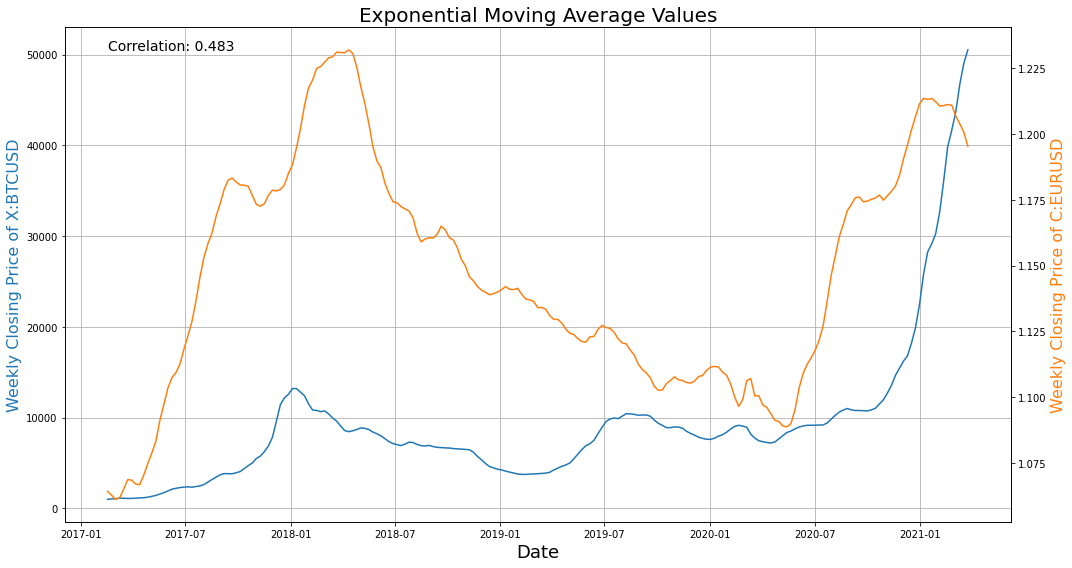

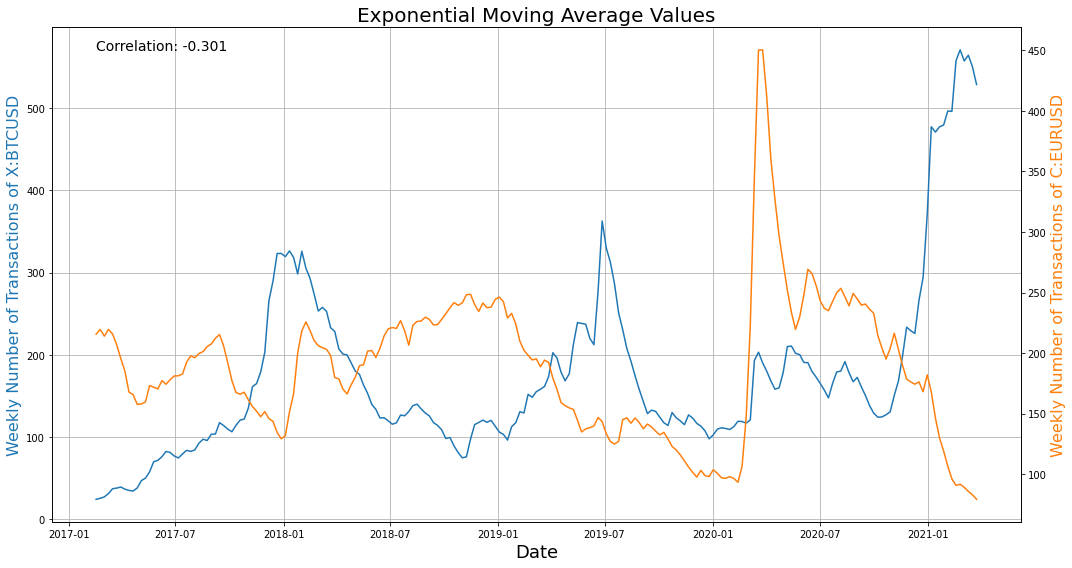

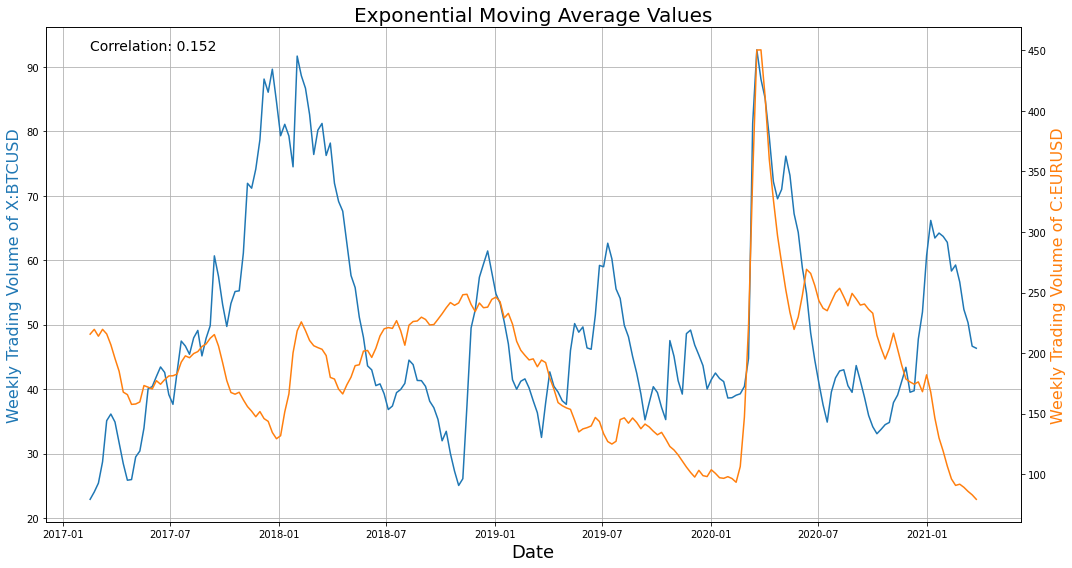

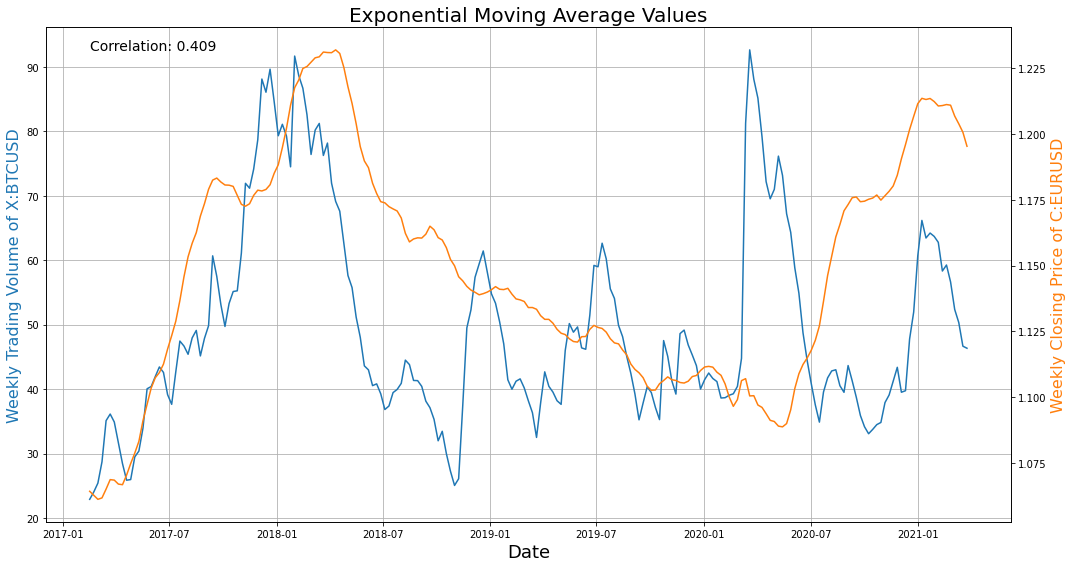

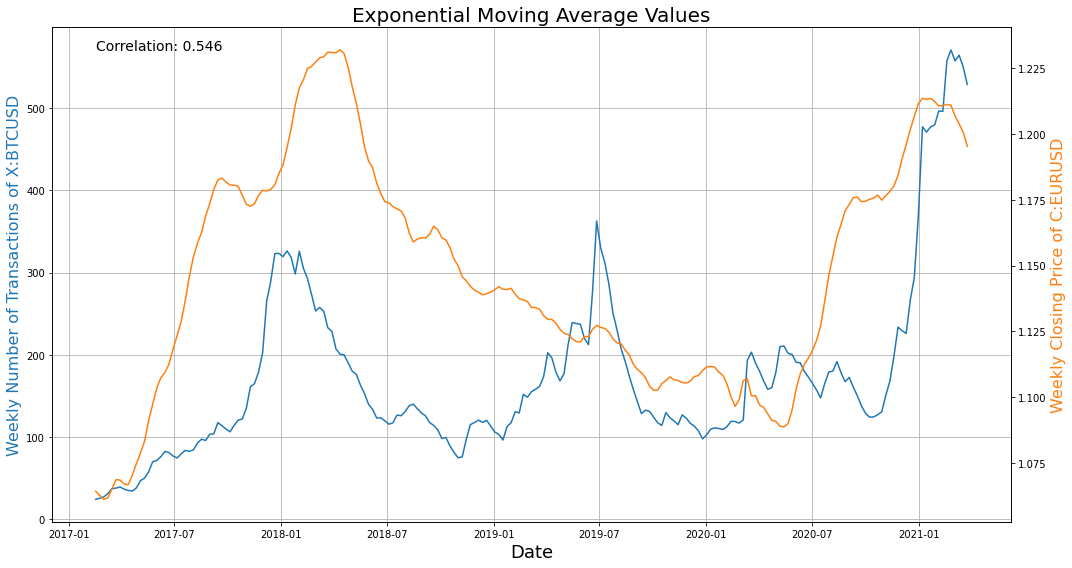

In [7]:
def monthly_ticks(axs, x, y, c, t):
  axs.plot(x, y, color = c)
  axs.set_title(t, fontsize = 20)

  fmt_month = mdates.MonthLocator(interval=1)
  axs.xaxis.set_major_locator(fmt_month)

  axs.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

  axs.format_xdata = mdates.DateFormatter('%Y-%m')
  axs.grid(True)

def plot_simple(f, crypto, forex, data):
  title = 'Exponential Moving Average Values'
  col_crypto = '{}_{}'.format(crypto, f[0])
  col_forex = '{}_{}'.format(forex, f[1])
  f_values = {'c': 'Closing Price', 'n': 'Number of Transactions', 'v': 'Trading Volume'}

  fig, axs = plt.subplots(figsize=(15, 8))
  timesteps = [datetime.strptime(r[:10], '%Y-%m-%d') for r in data['time']]
  monthly_ticks(axs, timesteps, data[col_crypto], '#1f77b4', title)

  ax2 = axs.twinx()
  ax2.plot(timesteps, data[col_forex], color = '#ff7f0e')
  axs.set_ylabel('Weekly {} of {}'.format(f_values[f[0]], crypto), color='#1f77b4', fontsize = 16)
  ax2.set_ylabel('Weekly {} of {}'.format(f_values[f[1]], forex), color='#ff7f0e', fontsize = 16)
  axs.set_xlabel('Date', fontsize = 18)

  corr = data[col_crypto].corr(data[col_forex])
  plt.text(timesteps[0], max(data[col_forex]), 'Correlation: {}'.format(round(corr, 3)), fontsize = 14)
  plt.tight_layout()
  #plt.show()
  # uncomment to save figure file
  plt.savefig("{}_{}_{}_{}.png".format(f[0], crypto, f[1], forex))

measure_pairs = [('c','c'), ('n', 'n'), ('v', 'v'), ('v', 'c'), ('n', 'c')]
for m in measure_pairs:
  plot_simple(m, crypto, forex, data)

### Try rolling correlation for measurement pair that has highest correlation value (num trades of bitcoin and closing price of EURUSD)

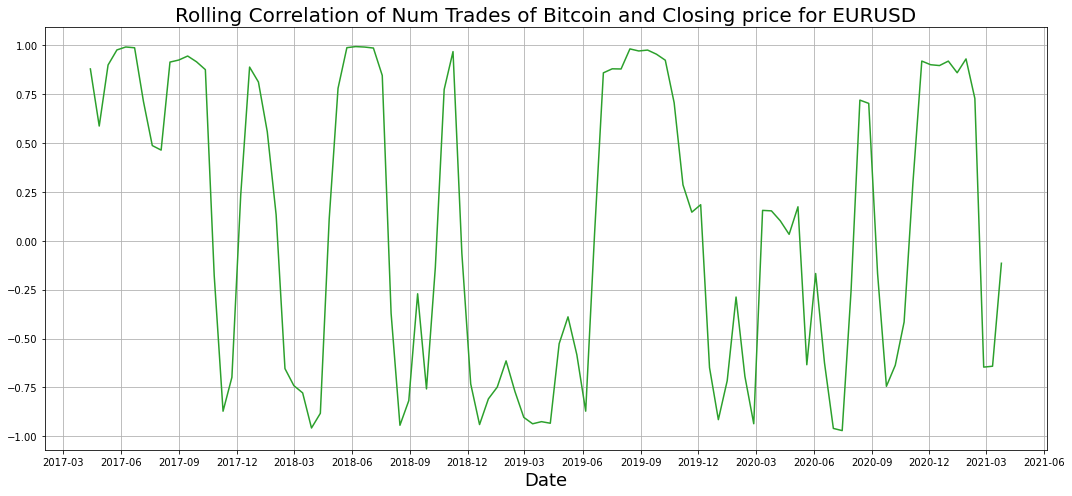

In [8]:
def monthly_ticks2(axs, x, y, c, t):
  axs.plot(x, y, color = c)
  axs.set_title(t, fontsize = 20)

  fmt_month = mdates.MonthLocator(interval=3)
  axs.xaxis.set_major_locator(fmt_month)

  axs.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

  axs.format_xdata = mdates.DateFormatter('%Y-%m')
  axs.grid(True)

fig, axs = plt.subplots(figsize=(15, 7))
rolling_corr = data['X:BTCUSD_n'].rolling(8).corr(data['C:EURUSD_c'])[::2]
rolling_timesteps = [datetime.strptime(r[:10], '%Y-%m-%d') for r in data['time']][::2]
monthly_ticks2(axs, rolling_timesteps, rolling_corr, '#2ca02c', "Rolling Correlation of Num Trades of Bitcoin and Closing price for EURUSD")
axs.set_xlabel("Date", fontsize = 18)

plt.tight_layout()
#plt.show()
# uncomment to save figure file
plt.savefig('corr_n_X:BTCUSD_c_C:EURUSD.png')